# Mapping Cities as FLows

## Open Packages

In [ ]:
from pandas.api.types import CategoricalDtype
#for setting timestamp on output data
import datetime
#for createing and editing tables
import pandas as pd
#for creating spatial tables
import geopandas as gpd
#for maths operations
import numpy as np
#for loading in data from and querying postgres
import sqlalchemy as db
#for manipulating geometries
from shapely.geometry import Point, LineString, box, mapping, Polygon
#for the H3 hex grid 
from h3 import h3
#for extracting osm data using a bounding region
import pyrosm
#for unsupervised learning
import scipy.cluster.hierarchy as shc
#for map visualisations
import matplotlib.pyplot as plt
#for faster spatial indexing
from sklearn.neighbors import BallTree
#for machine learning preperation
from sklearn import preprocessing
#for importing the random forest
import pickle
#for loading in data from google cloud
from google.cloud import storage
import os
from math import *

## Open Data

In [ ]:
# Create a database connection
# Create a database connection


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# GC credentials
data = pd.read_pickle('geolife.pkl')  # reads 'geolife.pkl' into df

In [ ]:
#specifiy csv files to load into the process
filter_required = (data['label']== 6) | (data['label']== 5) | (data['label']== 4) | (data['label']== 1) | (data['label']== 3)
data = data[filter_required]

In [ ]:
data = data.reset_index()
data.rename(columns={'index':'identifier','user':'uid', 'lon':'longitude', 'lat':'latitude','time':'timestamp'},inplace=True)

In [ ]:
data = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

In [ ]:
#hex_grid at zoom level 6 - for precalculated process
# Read PostGIS database with Geopandas
sql = 'SELECT * FROM public.hex_grid7;'
hex_grid = gpd.read_postgis(sql=sql, con=con)
hex_grid = hex_grid.rename(columns={'index':'hex_id'})

# Read PostGIS database with Geopandas - for precalcualted process
sql = 'SELECT * FROM public.hex_grid6;'
hex_grid6 = gpd.read_postgis(sql=sql, con=con)
hex_grid6 = hex_grid6.rename(columns={'index':'hex_id'})
# Read PostGIS database for tranist ways
sql = 'SELECT * from transit_way_bejing;'
transit_way = gpd.read_postgis(sql=sql, con=con)

# Read PostGIS database for transit relation
sql = 'SELECT * FROM public.transit_relation_bejing;'
transit_relation = gpd.read_postgis(sql=sql, con=con)
train_relation = transit_relation[transit_relation['route']=='train']
subway_relation = transit_relation[transit_relation['route']=='subway']
rail_relation = transit_relation[transit_relation['route']=='railway']
rail_relation = gpd.GeoDataFrame(rail_relation, crs='epsg:4326')
subway_relation = gpd.GeoDataFrame(subway_relation, crs='epsg:4326')
train_relation = gpd.GeoDataFrame(train_relation, crs='epsg:4326')
rail_relation['transport_lin'] = 'rail_line'
subway_relation['transport_lin'] = 'rail_line'
train_relation['transport_lin'] = 'rail_line'

# Read PostGIS database with bus routes
metro_bus_lines = transit_relation[transit_relation['route']=='bus']

metro_bus_relation = transit_relation[transit_relation['route']=='bus']
metro_bus_relation['transport_lin'] = 'bus_line'

# Read PostGIS database with motorway features
sql = 'SELECT * FROM public.motorway_beijing;'
transit_motorway_line = gpd.read_postgis(sql=sql, con=con)
# Read PostGIS database with Geopandas
sql = 'SELECT * FROM public.regional_bus_lines;'
regional_bus_lines = gpd.read_postgis(sql=sql, con=con)
regional_bus_relation = gpd.read_postgis(sql=sql, con=con)

## Define key functions

In [ ]:
#set the geometry build a spatial dataframe
data = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
#generate a seperate lat and long
#data['device_lon'] = data.geometry.apply(lambda p: p.x)
#data['device_lat'] = data.geometry.apply(lambda p: p.y)

In [ ]:
#function to get distance between the GPS points
def get_distance(lat, lng, lat_prev, lon_prev):
    # Transform to radians
    lng, lat, lon_prev, lat_prev = map(radians, [lng,  lat, lon_prev, lat_prev])
    dist_longit = lon_prev - lng
    dist_latit = lat_prev - lat
    # Calculate area
    area = sin(dist_latit/2)**2 + cos(lat) * cos(lat_prev) * sin(dist_longit/2)**2
    # Calculate the central angle
    central_angle = 2 * asin(sqrt(area))
    radius = 3956 # Use 6371 for km
    # Calculate Distance
    distance = central_angle * radius
    return abs(round(distance, 2))

In [ ]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    # Notice: should be in Lat/Lon format 
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [ ]:
# This functions returns a gridded bounding box (as a GeoDataFrame) using h3 or quadkeys
def load_grid(grid_type, zoom, bbox):
    list_hexagons = []
    list_hex_id = []
    if str.lower(grid_type) == 'h3' or str.lower(grid_type) == 'any':
        list_hex_id = list(h3.polyfill(geojson = mapping(bbox), res = zoom, geo_json_conformant=True))
        list_hexagons = list(map(lambda x : Polygon(h3.h3_to_geo_boundary(h=x, geo_json=True)), list_hex_id))
    elif str.lower(grid_type) == 'qk':
        bounds = bbox.bounds
        list_hex_id = list(map(mercantile.quadkey, 
                               mercantile.tiles(bounds[0], bounds[1], bounds[2], bounds[3], zooms=zoom)))
        list_hexagons = list(map(lambda x:box(*mercantile.bounds(x)),
                                 mercantile.tiles(bounds[0], bounds[1], bounds[2], bounds[3], zooms=zoom)))
    
    grid = pd.DataFrame({'hex_id': list_hex_id, 'geometry':list_hexagons})
    grid = gpd.GeoDataFrame(grid, crs='epsg:4326')
    return grid

In [ ]:
def f_line(row):
    """
    This function takes all OSM rail features and and labels them as a 'train_line'.
    
    """
    if row['route']=='subway':
        val = 'train_line'
    elif row['route']=='railway':
        val = 'train_line'
    elif row['route']=='train':
        val = 'train_line'
    elif row['railway']=='rail':
        val = 'train_line'
    else:
        val = None
    return val

In [ ]:
#break out multipart string
def multi2single(gpdf):
    gpdf_singleline = gpdf[gpdf.geometry.type == 'LineString']
    gpdf_multiline = gpdf[gpdf.geometry.type == 'MultiLineString']

    for i, row in gpdf_multiline.iterrows():
        Series_geometries = pd.Series(row.geometry)
        df = pd.concat([gpd.GeoDataFrame(row, crs=gpdf_multiline.crs).T]*len(Series_geometries), ignore_index=True)
        df['geometry']  = Series_geometries
        gpdf_singleline = pd.concat([gpdf_singleline, df])

    gpdf_singleline.reset_index(inplace=True, drop=True)
    return gpdf_singleline

In [ ]:
#this function densifys the line feature creating many vertices at the step size of choice
def densify_geometry (line_geometry, step, crs=None):
        
        #crs: epsg code of a coordinate reference system you want your line to be georeferenced with
        # step: add a vertice every step in whatever unit your coordinate reference system use.
    
        length_m=line_geometry.length # get the length
    
        xy=[] # to store new tuples of coordinates
    
        for distance_along_old_line in np.arange(0,(length_m),step): 
    
            point = line_geometry.interpolate(distance_along_old_line) # interpolate a point every step along the old line
            xp,yp = point.x, point.y # extract the coordinates
    
            xy.append((xp,yp)) # and store them in xy list
    
        new_line=LineString(xy) # Here, we finally create a new line with densified points.
        
        if crs != None:  #  If you want to georeference your new geometry, uses crs to do the job.
            new_line_geo=gpd.geoseries.GeoSeries(new_line,crs=crs) 
            return new_line_geo
    
        else:
            return new_line

## Append additional variables to original data feature

In [16]:
#removes error on copy of a slice
data['accuracy'] = 4
data = data.copy()
#rename the attribution
#data.rename(columns={'identifier':'uid', 'source_id': 'aid','device_lon':'longitude', 'device_lat':'latitude','device_horizontal_accuracy':'accuracy', 'province_short':'state', 'time_zone_name':'time_zone'},inplace=True)
#edit the feature types of those that are incorrectly strings
data['longitude'] = data['longitude'].astype(float)
data['latitude'] = data['latitude'].astype(float)
data['accuracy'] = data['accuracy'].astype(float)
# Calculate the corresponding h3id and the geometry associated to it (changed to 9 to evaluate difference)
data['hex_id'] = list(map(lambda p : h3.geo_to_h3(p[1], p[0], resolution=8), data[['longitude', 'latitude']].values))
data['hex_geom'] = list(map(lambda x : Polygon(h3.h3_to_geo_boundary(h=x, geo_json=True)), data['hex_id'].tolist()))

In [17]:
#removes error on copy of a slice
data_grouped = data.copy()
#group data by the uidand count the number of hex polygons at zoom level 8 it intersects
data_grouped = data_grouped.groupby('uid').agg({'hex_id':'nunique'}).reset_index()

In [18]:
#more than 4 hex grids must be traversed - removes stationary devices
more_than_4 = data_grouped[data_grouped['hex_id']>=4]
#rename hex feature
more_than_4 = more_than_4.rename(columns={'hex_id':'hex_id_n'})
#reindex
more_than_4 = more_than_4.reset_index(drop=True)

In [19]:
#edit the datatypes
data['uid'] = data['uid'].astype(str)
more_than_4['uid'] = more_than_4['uid'].astype(str)
more_than_4['hex_id_n'] = more_than_4['hex_id_n'].astype(str)

In [20]:
#dat ais only retained when it has more than for hex ids
data = more_than_4.set_index('uid').join(data.set_index('uid'), how='inner', rsuffix='_other')
# Filter pings based on accuracy
data = data[data['accuracy']<50] 
#set the time to be America/Neyyork 
data['datetime'] = data.apply(lambda row: pd.Timestamp(row['timestamp'], tz='America/New_York'), axis = 1)
#set the datetime
data['timestamp'] = data.apply(lambda row: pd.to_datetime(row['timestamp'], origin='unix'), axis = 1)
data = data.reset_index()
#remove any duplicate values
data = data.drop_duplicates(subset=['uid', 'longitude', 'latitude', 'timestamp', 'accuracy'])
#remove any null values
data = data.dropna(subset=['uid', 'longitude', 'latitude', 'timestamp', 'accuracy'])
#return the hour
data['hour'] = data['datetime'].dt.hour
#return the day of the week
data['dayofweek'] = data['datetime'].dt.dayofweek
#return the day of the year
data['dayofyear'] = data['datetime'].dt.dayofyear
#return the order of the event poitns
data['rank'] = data.groupby('uid')['timestamp'].rank(ascending=True).astype(int)

## Generalsise data

In [21]:
#generalise the datat to be one point every 4 mins
data['minute'] = data['timestamp'].dt.minute

data.loc[(data['minute'] <= 4), 'period'] = 0
data.loc[(data['minute'] > 4) & (data['minute'] < 8), 'period'] = 4
data.loc[(data['minute'] >= 8) & (data['minute'] < 12), 'period'] = 8
data.loc[(data['minute'] >= 12) & (data['minute'] < 16), 'period'] = 12
data.loc[(data['minute'] >= 16) & (data['minute'] < 20), 'period'] = 16
data.loc[(data['minute'] >= 20) & (data['minute'] < 24), 'period'] = 20
data.loc[(data['minute'] >= 24) & (data['minute'] < 28), 'period'] = 24
data.loc[(data['minute'] >= 28) & (data['minute'] < 32), 'period'] = 28
data.loc[(data['minute'] >= 32) & (data['minute'] < 36), 'period'] = 32
data.loc[(data['minute'] >= 36) & (data['minute'] < 40), 'period'] = 36
data.loc[(data['minute'] >= 40) & (data['minute'] < 44), 'period'] = 40
data.loc[(data['minute'] >= 44) & (data['minute'] < 48), 'period'] = 44
data.loc[(data['minute'] >= 48) & (data['minute'] < 52), 'period'] = 48
data.loc[(data['minute'] >= 52) & (data['minute'] < 56), 'period'] = 52
data.loc[(data['minute'] >= 56) & (data['minute'] <= 60), 'period'] = 56

data['period'] = data['period'].astype(int)
data['time_group'] =  (data['dayofyear'].astype(str))+(data['hour'].astype(str))+(data['period'].astype(str))
data['time_group'] = data['time_group'].astype(int)

data = data.groupby(['uid','time_group']).agg({'hex_id_n':'first','uid':'first', 'identifier':'first', 'timestamp':'first', 'latitude':'first', 'longitude':'first', 'alt':'first', 'label':'first', 'geometry':'first', 'hex_id':'first', 'hex_geom':'first', 'accuracy':'first','minute':'first','period':'first','hour':'first','time_group':'first','dayofyear':'first', 'dayofweek':'first'})
#'time_calc':'first','full_dist':'first'
#'total_trip_time':'first','overall_full_dist':'first','count_pts':'count', 

In [22]:
data = data.reset_index(drop=True)

In [23]:
data['rank'] = data.groupby('uid')['timestamp'].rank(ascending=True).astype(int)

## Calculate variables from the previous point feature

In [24]:
#sort the values by their rank and within each unique user
data = data.sort_values(["uid", "rank"], ascending = (False, True))
#attain the longitude of the preious
data['latitude_prev'] = data.groupby(['uid'])['latitude'].shift(1)
#attain the latiudue of the previous
data['longitude_prev'] = data.groupby(['uid'])['longitude'].shift(1)
#attain the timestamp of the previous
data['timestamp_prev'] = data.groupby(['uid'])['timestamp'].shift(1)

In [25]:
#set the timestamp of the previous to be unix datetime
data['timestamp_prev'] = data.apply(lambda row: pd.to_datetime(row['timestamp_prev'], origin='unix'), axis = 1)
#calulate the distance between the current and previous GPS point
data['great_circle'] = data.apply(lambda row: get_distance(row['latitude'], row['longitude'], row['latitude_prev'], row['longitude_prev']), axis = 1)
#get the second difference between the current and previous point
data['sec_diff'] = data['timestamp'] - data['timestamp_prev']
#set these to be seconds
data['sec_diff'] = data['sec_diff'] / np.timedelta64(1, 's')

In [26]:
#set all the null values from this to be zero
data[['sec_diff']] = data[['sec_diff']].fillna(value=0)
#speed calc
data['velo'] = data['great_circle']/data['sec_diff']
#fill the null values as zero
data[['velo']] = data[['velo']].fillna(value=0)
#reset index
data = data.reset_index(drop=True)
#velo times 60 to get mph
data['velo'] = (data['velo']*60)*60

## Identify trips

In [27]:
#define a trend like to find consectuve hex ids
data['trend'] = data.uid.groupby(data.hex_id.ne(data.hex_id.shift()).cumsum()).cumcount()
#grouped = data.groupby('uid')
data["tripID"] = ""
data = data.reset_index(drop=True)

In [28]:
#define a vectorised condition that breaks the sequence into a trip when the velcity is greater than 75mph, there are more than 3 GPS points in the same zoom level 8 hex
import time
start = time.time()

data['condition'] = (data['sec_diff']> 400) | (data['trend']>=3)| (data['velo']>75)

data['tripID'] = data.groupby('uid')['condition'].cumsum()

data['tripID'] += 1

print('Elapsed time:', time.time()- start)

Elapsed time: 0.010991096496582031


In [29]:
data = data.copy()

In [30]:
#as the current trip ids are a series of numbers append the trip id to the user id to establish the trip number
data['tripID'] = data['tripID'].astype(int)
data['U_trip_ID'] = data["uid"].astype(str) +'-'+ data["tripID"].astype(str)
#establish the number of unique trip ids
counts = data['U_trip_ID'].value_counts()
#only bring through when there is at least more than 3 vertices on a trip
data = data[data['U_trip_ID'].isin(counts.index[counts >= 3])]
#establish new features (duplicates) to be edited whilst retaining the original
data['time_calc'] = data['sec_diff']
data['full_dist'] = data['great_circle']

In [31]:
#the first value in the trip must have a value of 0 for the distance and the time value 
data.loc[data.groupby('U_trip_ID')['sec_diff'].head(1).index, 'time_calc'] = 0
data.loc[data.groupby('U_trip_ID')['great_circle'].head(1).index, 'full_dist'] = 0
#create a lookup table groupby the unque trip ids and gain the full trip duration and distane and count of vertices
lookup = data.groupby(['U_trip_ID']).agg({'time_calc' : 'sum', 'full_dist': 'sum', 'U_trip_ID' : 'count'})
#rename the lookup table attributes
lookup = lookup.rename(columns={'U_trip_ID':'count_pts', 'time_calc':'total_trip_time', 'full_dist':'overall_full_dist'})

In [32]:
#for each of the individual point features append the details of the full trip
data = pd.merge(data, lookup, left_on = 'U_trip_ID', right_index=True, how = 'left')
#make data a geodataframe once more
data = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

In [33]:
#create line features from the trip IDs appending values to a list
trip_line = data.groupby(['U_trip_ID'])['geometry'].apply(lambda x: LineString(x.tolist()))
#make the line feature a geometry
trip_line = gpd.GeoDataFrame(trip_line, geometry='geometry')
trip_line = trip_line.reset_index()
#make time an integer
data['time_calc'] = data['time_calc'].astype(int)

In [34]:
date_range = str(data['timestamp'].dt.date.min()) + ' to ' +str(data['timestamp'].dt.date.max())
date_range

'2007-04-14 to 2011-12-31'

In [35]:
data['rank'] = data.groupby('uid')['timestamp'].rank(ascending=True).astype(int)
data= data.sort_values(["uid", "rank"], ascending = (False, True))

[]

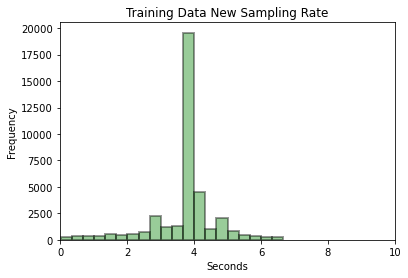

In [36]:
import seaborn as sns
#distribution of mean vote
g = sns.distplot(((data[data['time_calc']>0]['time_calc'])/60),
             #specify histgram
             hist=True,
             #not kde plot
             kde=False,
             #do not add rug plot
             rug=False,
             #select 80 bins
             bins=20,
                 hist_kws=dict(edgecolor="k", linewidth=2),
             #select axes
             #ax=axs[0,1]
             color='green')
g.set(xlim=(0, 10), ylim=(0, None), xlabel='Seconds', ylabel='Frequency')
g.set_title('Training Data New Sampling Rate')
#g.figure.savefig("output_sampling_geolife.png")
g.plot()


## Spatial feature Context 

### motorway

In [37]:
transit_motorway_line = gpd.GeoDataFrame(transit_motorway_line, crs='epsg:4326')
#transit_motorway_line['transport_poi'] = 'motorway'
transit_motorway_line['transport_lin'] = 'motorway_line'
transit_motorway_line = gpd.GeoDataFrame(transit_motorway_line, crs='epsg:4326')

C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  """Entry point for launching an IPython kernel.
C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  after removing the cwd from sys.path.


### Railway

In [38]:
#set the rail features to be trains
transit_relation['trns_type'] = transit_relation.apply(f_line, axis=1)
#filter only required columns
transit_relation = transit_relation[['id','trns_type','geom']]
#esnure all are trains
transit_relation = transit_relation[transit_relation['trns_type']=='train_line']
#label way features as train lines
transit_way['trns_type'] = transit_way.apply(f_line, axis=1)
#filter only required columns
transit_way = transit_way[['id','trns_type','geom']]
#ensure all ways are trains
transit_way = transit_way[transit_way['trns_type']=='train_line']
#join the ways to the realtions to get completed train route
transit_relation = transit_relation.append(transit_way)
#rename geometry
transit_relation = transit_relation.rename(columns={'geom': 'geometry'})
#set as a geodataframe
transit_relation = gpd.GeoDataFrame(transit_relation, crs='epsg:4326')
#make all multpart features singlepart
transit_relation = multi2single(transit_relation)
#transit_relation = transit_relation[transit_relation['trns_type'] == 'train_line']
#remove short sections of the train line
transit_relation = transit_relation[transit_relation.geometry.length > 0.0001]
#densify the railway line geometry for distance calcs
transit_relation['geometry'] = transit_relation.geometry.apply(densify_geometry, step=0.0001, crs = None)
#transport line into a list of points
transit_relation['point_list'] = transit_relation['geometry'].apply(lambda geom : list(geom.coords))
# Need to cast to DataFrame because the explode method for a GeoDataFrame means something different
#explode the points list into a record for each point
transit_relation = pd.DataFrame(transit_relation).explode('point_list')
# Transform lat/lon tuple into Point geometry
transit_relation['point_list'] = transit_relation['point_list'].apply(lambda coor : Point(*coor))
# Need to turn it into a GeoDataFrame again
transit_relation = gpd.GeoDataFrame(transit_relation, crs='epsg:4326')
#reset the geoemtry to be the new point
transit_relation = transit_relation.set_geometry('point_list')

C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  
C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



### Bus routes

In [39]:
#create a string for each bus feature to label on intersection
regional_bus_lines['trns_type'] = 'bus_line'
#filter only sttributes required
regional_bus_lines = regional_bus_lines[['id','trns_type','geom']]
#rename the geometry
regional_bus_lines = regional_bus_lines.rename(columns={'geom': 'geometry'})
#make bus lines a geodataframe
regional_bus_lines = gpd.GeoDataFrame(regional_bus_lines, crs='epsg:4326')
#make these single part features
regional_bus_lines = multi2single(regional_bus_lines)
#densify the bus route line features
regional_bus_lines = regional_bus_lines[regional_bus_lines.geometry.length > 0.0001]

C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  
C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if sys.path[0] == '':


In [40]:
#create string for each inner city bus line
metro_bus_lines['trns_type'] = 'bus_line'
#alter the name of the unique identfier
metro_bus_lines = metro_bus_lines.rename(columns={'objectid': 'id'})
#filter to only keep variables required
metro_bus_lines = metro_bus_lines[['id','trns_type','geom']]
#rename geometry column
metro_bus_lines = metro_bus_lines.rename(columns={'geom': 'geometry'})
#change to geoedataframe
metro_bus_lines = gpd.GeoDataFrame(metro_bus_lines, crs='epsg:4326')
#change multpart to single part
metro_bus_lines = multi2single(metro_bus_lines)
#density the bus line feature (this was for the old euclidean distacne calcs on buses)
metro_bus_lines = metro_bus_lines[metro_bus_lines.geometry.length > 0.0001]

C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  
C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [41]:
#join inner city bus lines to regional bus routes
metro_bus_lines = regional_bus_lines.append(metro_bus_lines)

In [42]:
metro_bus_relation = gpd.GeoDataFrame(metro_bus_lines, crs='epsg:4326')

In [43]:
metro_bus_relation.rename(columns={'geom':'geometry', 'objectid':'id'},inplace=True)

In [44]:
#append the points of the bus route to a list
metro_bus_lines['point_list'] = metro_bus_lines['geometry'].apply(lambda geom : list(geom.coords))
# Need to cast to DataFrame because the explode 
metro_bus_lines = pd.DataFrame(metro_bus_lines).explode('point_list')
# Transform lat/lon tuple into Point geometry
metro_bus_lines['point_list'] = metro_bus_lines['point_list'].apply(lambda coor : Point(*coor))
# Need to turn it into a GeoDataFrame again
metro_bus_lines = gpd.GeoDataFrame(metro_bus_lines, crs='epsg:4326')
#set the geoemtry to the points of the bus routes (for distance calculations - not used in final version)
metro_bus_lines = metro_bus_lines.set_geometry('point_list')

In [45]:
data = data.reset_index()

## Calculate distances for Train line

In [46]:
start = time.time()
# get the distance between points in meters, to the train line
closest_lines = nearest_neighbor(data, transit_relation, return_dist=True)
print('Elapsed time:', time.time()- start)

Elapsed time: 38.45293569564819


In [47]:
#eranme the distance to be dist_trns_ln, and then rename the trns_type to be a trns_line_type
closest_lines = closest_lines.rename(columns={'trns_type':'trs_line_type' })
closest_lines = closest_lines.rename(columns={'distance':'dist_trns_line' })
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_lines = closest_lines.rename(columns={'point_list': 'closest_line_geom'})
#drop the original line geoemtry on the closest line dataframe
closest_lines = closest_lines.drop('geometry',axis=1,inplace=False)
#drop the id as no longer required
closest_lines = closest_lines.drop('id',axis=1,inplace=False)
#join the attribute for the distance to the closest train geometry
data = data.join(closest_lines)

In [48]:
closest_lines

,trs_line_type,closest_line_geom,dist_trns_line
0,train_line,POINT (116.40017 39.89922),276.542984
1,train_line,POINT (116.40053 39.89923),122.014488
2,train_line,POINT (116.40074 39.89929),2.350622
3,train_line,POINT (116.33119 39.97516),8.209190
4,train_line,POINT (116.32899 39.97502),3.289529
...,...,...,...
43626,train_line,POINT (116.30052 39.91562),858.522696
43627,train_line,POINT (116.30524 39.94108),121.482351
43628,train_line,POINT (116.30156 39.96162),270.183753
43629,train_line,POINT (116.33780 39.96886),589.946631


## Georeferencing

In [49]:
#get h3 grid at zoom level 8
bbox = box(115.9776,39.5343,116.8527,40.3028)
#load h3_grid
h3_grid = load_grid('h3',8,bbox)

In [50]:
metro_bus_relation['transport_lin'] = 'bus_line'

In [51]:
#rename the geometry column
train_relation.rename(columns={'geom':'geometry'},inplace=True)
transit_motorway_line.rename(columns={'geom':'geometry'},inplace=True)
#list columns to keep
col_list2 = ['transport_lin', 'geometry',\
                       'id']
#filter only columns that are required
train_relation = train_relation[col_list2]
metro_bus_relation = metro_bus_relation[col_list2]
transit_motorway_line = transit_motorway_line[col_list2]

In [52]:
#append all spatial context features into one geodataframe
ll = train_relation.append(metro_bus_relation).append(transit_motorway_line)
ll = gpd.GeoDataFrame(ll, crs='epsg:4326')
ll.tail(1)

,transport_lin,geometry,id
5303,motorway_line,"LINESTRING (116.17282 39.78176, 116.17314 39.7...",962714848


In [53]:
#make h3 grid_list a geodataframe
h3_grid = gpd.GeoDataFrame(h3_grid, crs='epsg:4326')
#do a spatial join on the h3 grid (zoom level 8)
h3_grid_line = gpd.sjoin(h3_grid, ll, how='inner', op='intersects')
#produce a dataframe merge of the features that the h3 grid intersects
list_of_feat_lin = h3_grid.merge(h3_grid_line, on='hex_id').groupby(['hex_id']).agg({'transport_lin':list}).reset_index()

In [54]:
#only one of the features names in the collection as a set of a possible 3
list_of_feat_lin['transport_lin'] = list_of_feat_lin.apply(lambda row: list(set(row['transport_lin'])), axis = 1)

In [55]:
h3_grid['geometry'].intersects(ll['geometry'].values[0])
#add the list feature to the original geodataframe of points
data = data.merge(list_of_feat_lin, on='hex_id', how = 'left')

In [56]:
#make timestamp variables string for later extract to shapefile
data['timestamp_prev'] = data['timestamp_prev'].astype(str)
#data['datetime'] = data['datetime'].astype(str)
data['timestamp'] = data['timestamp'].astype(str)
data['transport_lin'] = data['transport_lin'].astype(str)

In [57]:
#make a boolean column to indicate the presence of a spatial feature
data['bus_line'] = np.where(data['transport_lin'].str.contains("bus_line"),1,0)
data['rail_line'] = np.where(data['transport_lin'].str.contains("rail_line"),1,0)
data['motorway_line'] = np.where(data['transport_lin'].str.contains("motorway_line"),1,0)

In [58]:
#define where the start of the jounery is (for possible use in closeness to bus-stops or train stations)
data['start'] = np.where(data['time_calc'] == 0, True, False)

In [59]:
#added to stop kickbacks and jumps in distance
data['velo'] = np.where(data['time_calc'] == 0, 0, data['velo'])
#make the distance 0 at the start of the journey as well as the time
data['great_circle'] = np.where(data['time_calc'] == 0, 0, data['great_circle'])

In [60]:
#if the GPS point is in 15 metres of the train line feature, create a value of in_range
data['in_range']= data.apply(lambda row: 1 if (row['dist_trns_line'] <= 15) else 0, axis= 1)

In [61]:
#create a function to attain the standard deviation
def std(x): 
    return np.std(x)

## Group the Trip features - Create attributes

In [62]:
#create the trip feature with attributes defined
trips = data.groupby(['U_trip_ID']).agg({'total_trip_time':'first', 'overall_full_dist': 'first', 'count_pts' : 'first', 'bus_line':'sum', 'rail_line':'sum', 'motorway_line':'sum', 'velo':['mean', std, 'max'], 'dist_trns_line':['mean', 'min', 'max'],'in_range':'sum', 'hour':'first', 'dayofweek':'first', 'dayofyear':'first', 'label':lambda x: x.value_counts().index[0]})

In [63]:
#delete data from cache
#del data

In [64]:
#create likelihood values
trips['train_conf'] = (trips['rail_line']['sum']/trips['count_pts']['first']).replace(np.inf, 0)
trips['bus_conf'] = (trips['bus_line']['sum']/trips['count_pts']['first']).replace(np.inf, 0)
trips['motorway_conf'] = (trips['motorway_line']['sum']/trips['count_pts']['first']).replace(np.inf, 0)

In [65]:
#do a merge on the unique trip id with the 
trips = trips.merge(trip_line, on='U_trip_ID', how= 'left')
#make into geodataframe
trips = gpd.GeoDataFrame(trips, geometry='geometry')
#replace infiity values with zero
trips[('velo', 'mean')] = trips[('velo', 'mean')].replace(np.inf, 0)

C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [66]:
#replace infinite values with zero
trips[('velo', 'max')] = trips[('velo', 'max')].replace(np.inf, 0)

In [67]:
#rename attributes to more logical names
trips = trips.rename(columns={('velo', 'mean') : "velo_mean", ('train_conf', ''): "train_conf",('motorway_conf', ''): "motorway_conf",('bus_conf', ''): "bus_conf", ('dist_trns_line', 'mean'):"dist_trns_line", ('velo', 'max'):"max_velo",('velo', 'std'):"std_velo", ('overall_full_dist', 'first'):'overall_full_dist', ('total_trip_time', 'first'):'total_trip_time', ('closest_motorway_dst', 'mean'):'closest_motorway_dst',('in_range', 'sum'):'in_range', ('dist_trns_busline', 'mean'):'dist_trns_busline', ('label', '<lambda>'):'label'}) 

In [68]:
#ensure that trips are not 0 distance
trips = trips[trips['overall_full_dist']>0]

In [69]:
#version of the trip features ready for extraction
tripsA= trips.loc[:, ['total_trip_time', 'overall_full_dist','train_conf', 'velo_mean','max_velo', 'bus_conf','motorway_conf','in_range','std_velo','dist_trns_line','geometry']]
tripsA = gpd.GeoDataFrame(tripsA)

## Rule-Based Classifier - Label Trains

In [70]:
#the rule to identify trains
def trains_(row):
    if (row['train_conf']>=0.55) and (((row['in_range']>=2) and (row['dist_trns_line']<=110))|(row['dist_trns_line']<=40)|(row['in_range']>=4)) and (row['velo_mean']>=10) and (row['max_velo']>=15)and (row['std_velo']>=6):
        val = 6     
    else:
        val = None
    return val

In [71]:
#run the train rule and add labels to the features identified as trains
trips['inf_labels'] = trips.apply(trains_, axis=1)
#make time minutes
trips['total_trip_time']= trips['total_trip_time']/60

In [72]:
trips['label'] = trips['label'].replace([5],6)

In [73]:
#Break apart the features already labeled with those that are not
walk_and_train = trips[trips.inf_labels.notnull()]
walk_and_train = walk_and_train.reset_index(drop=True)
cars_and_rest = trips[trips.inf_labels.isnull()]
walk_and_train = walk_and_train.reset_index(drop=True)

In [74]:
#full list of attribution to be retained
#data = trips.loc[:, ['total_trip_time', 'overall_full_dist', 'velo_mean','max_velo', 'std_velo','train_conf','bus_conf','train_conf','in_range','motorway_conf','dist_trns_line','label']].values

In [75]:
trips['label']

0       6
1       6
2       6
3       6
4       6
       ..
5840    6
5841    1
5842    1
5843    1
5844    3
Name: label, Length: 5839, dtype: int64

## Random Forest classifier - Creation

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix
#random forest full data
#now we can train the model
from sklearn.ensemble import RandomForestClassifier

In [77]:
wrong_labelled = cars_and_rest[(cars_and_rest['label']==6)]

In [78]:
cars_and_rest = cars_and_rest[(cars_and_rest['label']==3)|(cars_and_rest['label']==4)|(cars_and_rest['label']==1)]

In [79]:
#attribution used in the final version of the random forest 
X = cars_and_rest[['velo_mean','max_velo','std_velo','bus_conf','motorway_conf','overall_full_dist']]

In [80]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    cars_and_rest["label"],
                                                    test_size=0.7,
                                                   random_state=101)

In [81]:
rf_estimator = RandomForestClassifier(n_estimators=150,
                                     max_features=1, random_state = 101
                                    )
# Train on X/Y train
rf_estimator.fit(x_train, y_train)
# Predict on X test
pred_lbls = pd.Series(rf_estimator.predict(x_test),
                          index=x_test.index
                         )

In [82]:
predictions = rf_estimator.predict(x_test)

In [83]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.83      0.86      0.84      1457
           3       0.74      0.74      0.74      1274
           4       0.76      0.70      0.73       781

    accuracy                           0.78      3512
   macro avg       0.78      0.77      0.77      3512
weighted avg       0.78      0.78      0.78      3512



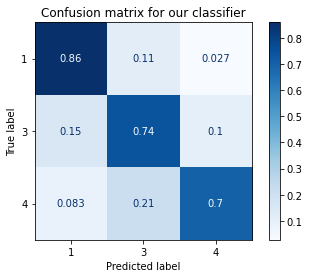

In [84]:
# Generate confusion matrix
matrix = plot_confusion_matrix(rf_estimator, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

In [85]:
predictions = rf_estimator.predict(X)

In [86]:
cars_and_rest['inf_labels'] = predictions

In [87]:
cars_and_rest = cars_and_rest.reset_index(drop=True)

In [88]:
#append tables
trips = walk_and_train.append(cars_and_rest).append(wrong_labelled)

In [89]:
trips['inf_labels'].value_counts()

1.0    2172
3.0    1826
4.0    1019
6.0     376
Name: inf_labels, dtype: int64

In [90]:
trips['label'].value_counts()

1    2128
3    1829
4    1084
6     798
Name: label, dtype: int64

In [91]:
def mode_of_trans(row):
    if row['label'] == 1:
        val = 'walk'
    elif row['label'] == 3:
        val = 'bus'
    elif row['label'] == 4:
        val = 'car'
    else:
        val = 'train'
    return val

In [92]:
def mode_of_trans2(row):
    if row['inf_labels'] == 1.0:
        val = 'walk'
    elif row['inf_labels'] == 3.0:
        val = 'bus'
    elif row['inf_labels'] == 4.0:
        val = 'car'
    elif row['inf_labels'] == 0:
        val = 'x_unclassified'
    else:
        val = 'train'
    return val

In [93]:
trips[['inf_labels']] = trips[['inf_labels']].fillna(value=0)

In [94]:
trips['label'] = trips.apply(mode_of_trans, axis=1)

In [95]:
trips['inf_labels'] = trips.apply(mode_of_trans2, axis=1)

## Calculate Variable Importance

In [96]:
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.ensemble._forest import _get_n_samples_bootstrap

In [97]:
def _get_unsampled_indices(tree, nsamples):
    X=x_train.values
    n_samples = len(X)
    n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
    return _generate_unsampled_indices(tree.random_state, n_samples, n_samples_bootstrap)

In [98]:
#permutation importance
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import random
def oob_classifier_accuracy(rf, x_train, y_train):
    x = x_train.values
    y= y_train.values
    
    n_samples = len(x)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _get_unsampled_indices(tree, n_samples)
        tree_preds = tree.predict_proba(x[unsampled_indices,:])
        predictions[unsampled_indices] += tree_preds
        
    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]
    
    oob_score = np.mean(y==predicted_classes)
    return oob_score

perm_imp_rfpimp = permutation_importances(rf_estimator, x_train, y_train, oob_classifier_accuracy)

In [99]:
random.seed(101)

In [100]:
X['random'] = np.random.random(size = len(X))

In [101]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    cars_and_rest["label"],
                                                    test_size=0.7
                                                   ,random_state=101)

In [102]:
rf_estimator2 = RandomForestClassifier(n_estimators=150,
                                     max_features=1,
                                    random_state=101)
# Train on X/Y train
rf_estimator2.fit(x_train, y_train)

RandomForestClassifier(max_features=1, n_estimators=150, random_state=101)

In [103]:
perm_imp_rfpimp = permutation_importances(rf_estimator2, x_train, y_train, oob_classifier_accuracy)
perm_imp_rfpimp

,Importance
Feature,
velo_mean,0.095681
std_velo,0.035880
overall_full_dist,0.027907
max_velo,0.025249
motorway_conf,0.014618
bus_conf,0.013953
random,0.007309


In [104]:
perm_imp_rfpimp = perm_imp_rfpimp.reset_index()

In [105]:
trips = trips.rename(columns={('velo', 'mean') : "velo_mean", ('train_conf', ''): "train_conf",('motorway_conf', ''): "motorway_conf",('bus_conf', ''): "bus_conf", ('dist_trns_line', 'mean'):"dist_trns_line", ('velo', 'max'):"max_velo",('velo', 'std'):"std_velo", ('overall_full_dist', 'first'):'overall_full_dist', ('total_trip_time', 'first'):'total_trip_time', ('closest_motorway_dst', 'mean'):'closest_motorway_dst',('in_range', 'sum'):'in_range', ('dist_trns_busline', 'mean'):'dist_trns_busline', ('label', '<lambda>'):'label'}) 

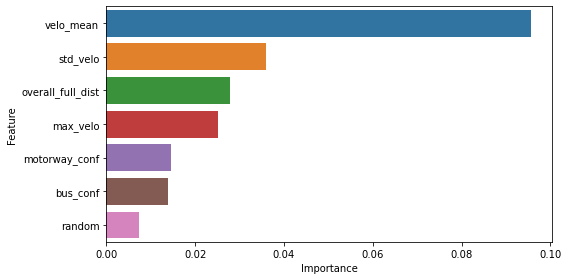

In [106]:
ax = plt.figure(figsize=(8,4))

sns.barplot(y="Feature", x="Importance", data=perm_imp_rfpimp)

plt.tight_layout()
plt.show()


In [107]:
trips['total_trip_time'] = trips['total_trip_time']/60

## Univariate Analysis of trips

Text(0.5, 0.98, 'Boxplots - Univariate comparison of trips')

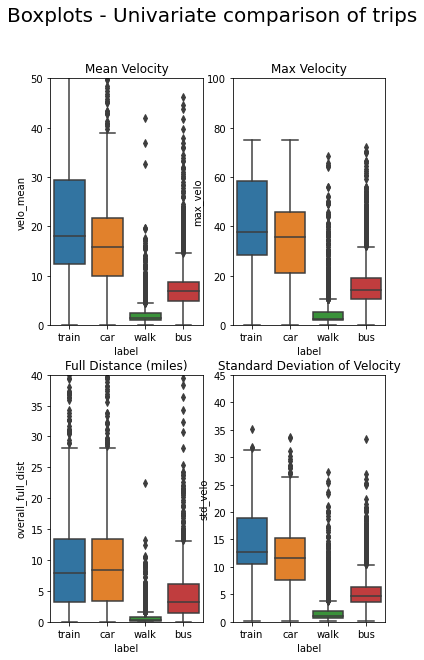

In [108]:
#Generate figure size as 15x16
fig4 = plt.figure(figsize=(6, 10))
#layout 2cols by 3rows
spec4 = fig4.add_gridspec(ncols=2, nrows=2)

#generate subplots in formation
f4_ax1 = fig4.add_subplot(spec4[0, 0])
f4_ax2 = fig4.add_subplot(spec4[0, 1])
f4_ax3 = fig4.add_subplot(spec4[1, 0])
f4_ax4 = fig4.add_subplot(spec4[1, 1])

#generate boxplot
sns.boxplot(y = "velo_mean",
            x = "label",
            data = trips,
            #colour by age
            #choose axis
            ax=f4_ax1
           )
sns.boxplot(y = "max_velo",
            x = "label",
            data = trips,
            #colour by gender
            #choose axis
            ax=f4_ax2
            #select alternative colour
           )
sns.boxplot(y = "overall_full_dist",
            x = "label",
            data = trips,
            #colour by gender
            #choose axis
            ax=f4_ax3
            #select alternative colour
           )
sns.boxplot(y = "std_velo",
            x = "label",
            data = trips,
            #colour by gender
            #choose axis
            ax=f4_ax4
            #select alternative colour
           )
f4_ax1.set_ylim(0,50)
f4_ax1.set_title('Mean Velocity')
#set $200 million y-limit
f4_ax2.set_ylim(0, 100)
f4_ax2.set_title('Max Velocity')
f4_ax3.set_ylim(0, 40)
f4_ax3.set_title('Full Distance (miles)')
f4_ax4.set_ylim(0, 45)
f4_ax4.set_title('Standard Deviation of Velocity')

fig4.suptitle('Boxplots - Univariate comparison of trips', fontsize=20)

## Display Average Values - Random Forest

In [109]:
tripsA = trips.loc[:, ['U_trip_ID','total_trip_time', 'overall_full_dist', 'velo_mean','max_velo','std_velo','dist_trns_line', 'bus_conf','motorway_conf','geometry','inf_labels','label', 'train_conf', 'in_range']]
g = tripsA.loc[:, ['total_trip_time', 'overall_full_dist','train_conf', 'velo_mean','max_velo', 'bus_conf','motorway_conf','in_range','std_velo','dist_trns_line']].groupby(tripsA['inf_labels'])
g.size()\
 .sort_values()
#generate the average
g2 = g.mean()
#round to 2 decimal places
g2 = g2.round(2)
#rename axis with Table 1 label
g2 = g2.rename_axis('TABLE 2 - RF MATRIX', axis=1)
g2

TABLE 2 - RF MATRIX,total_trip_time,overall_full_dist,train_conf,velo_mean,max_velo,bus_conf,motorway_conf,in_range,std_velo,dist_trns_line
inf_labels,,,,,,,,,,
bus,0.50,4.64,0.11,7.41,16.10,0.90,0.10,1.15,5.37,70338.90
car,0.55,12.28,0.14,18.18,37.74,0.66,0.31,0.64,12.73,241439.20
train,0.43,8.78,0.92,17.93,36.51,0.78,0.30,5.26,13.09,43.73
walk,0.22,0.57,0.16,2.04,4.85,0.71,0.08,0.45,1.85,63733.79
x_unclassified,0.65,25.53,0.20,23.88,42.27,0.24,0.04,0.66,14.77,438036.95


In [110]:
#append tables
#trips = walk_and_train.append(cars_and_rest)

## Display average values - Both Rules and RF

In [111]:
g = trips.loc[:, ['total_trip_time', 'overall_full_dist','train_conf', 'velo_mean','max_velo', 'bus_conf','motorway_conf','in_range','std_velo','dist_trns_line']].groupby(trips['label'])
g.size()\
 .sort_values()
#generate the average
g2 = g.mean()
#round to 2 decimal places
g2 = g2.round(2)
#rename axis with Table 1 label
g2 = g2.rename_axis('TABLE 2 - RF MATRIX', axis=1)
g2

TABLE 2 - RF MATRIX,total_trip_time,overall_full_dist,train_conf,velo_mean,max_velo,bus_conf,motorway_conf,in_range,std_velo,dist_trns_line
label,,,,,,,,,,
bus,0.49,4.88,0.10,7.69,16.46,0.90,0.11,1.13,5.53,28178.53
car,0.52,10.94,0.13,16.45,34.41,0.69,0.28,0.65,11.61,325461.64
train,0.55,18.18,0.52,21.36,39.80,0.48,0.15,2.70,14.06,244835.90
walk,0.23,0.77,0.17,2.32,5.54,0.70,0.08,0.49,2.07,51014.15


In [112]:
tripsA = trips.loc[:, ['U_trip_ID','total_trip_time', 'overall_full_dist', 'velo_mean','max_velo','std_velo', 'bus_conf','dist_trns_line','motorway_conf','geometry','inf_labels','label']]
g = tripsA.loc[:, ['total_trip_time', 'overall_full_dist', 'velo_mean','max_velo','std_velo', 'bus_conf','motorway_conf','dist_trns_line']].groupby(tripsA['inf_labels'])
g.size()\
 .sort_values()
#generate the average
g2 = g.mean()
#round to 2 decimal places
g2 = g2.round(2)
#rename axis with Table 1 label
g2 = g2.rename_axis('TABLE 2 - Real Vals MATRIX', axis=1)
g2

TABLE 2 - Real Vals MATRIX,total_trip_time,overall_full_dist,velo_mean,max_velo,std_velo,bus_conf,motorway_conf,dist_trns_line
inf_labels,,,,,,,,
bus,0.50,4.64,7.41,16.10,5.37,0.90,0.10,70338.90
car,0.55,12.28,18.18,37.74,12.73,0.66,0.31,241439.20
train,0.43,8.78,17.93,36.51,13.09,0.78,0.30,43.73
walk,0.22,0.57,2.04,4.85,1.85,0.71,0.08,63733.79
x_unclassified,0.65,25.53,23.88,42.27,14.77,0.24,0.04,438036.95


In [113]:
trips = trips.rename(columns={('dayofweek', 'first') : "dayofweek", ('hour', 'first') : "hour"})

In [114]:
#for extractions
tripsA = trips.loc[:, ['U_trip_ID','total_trip_time', 'overall_full_dist', 'velo_mean','max_velo', 'train_conf','bus_conf','std_velo', 'dist_trns_line','geometry','inf_labels','hour','dayofweek']]
tripsA = gpd.GeoDataFrame(tripsA, crs='epsg:4326')

In [115]:
#process to label the days from numbers to strings
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
cats = [ 'Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun']

In [116]:
#apply the process to label days
trips['dayofweek'] = trips['dayofweek'].apply(lambda x: days[x])

In [117]:
cat_type = CategoricalDtype(categories=cats, ordered=True)

In [118]:
trips['dayofweek'] = trips['dayofweek'].astype(cat_type)

In [119]:
trips = trips.rename(columns={('dayofweek', 'first') : "dayofweek", ('hour', 'first') : "hour"})

In [120]:
tripsA = gpd.GeoDataFrame(tripsA, crs='epsg:4326')
g = trips.groupby(['dayofweek','hour']).agg({'U_trip_ID':'count'})
g = g.reset_index().pivot(index='hour', columns='dayofweek', values='U_trip_ID')

## Create Temporal Heatmaps

In [121]:
h = trips.groupby(['inf_labels','dayofweek','hour']).agg({'U_trip_ID':'count'})
h = h.reset_index()

In [122]:
#for breaking apart the trips by transport mode to display as a heatmap
h1 = h[h['inf_labels']=='walk'].pivot(index='hour', columns='dayofweek', values='U_trip_ID')
h3 = h[h['inf_labels']=='bus'].pivot(index='hour', columns='dayofweek', values='U_trip_ID')
h6 = h[h['inf_labels']=='train'].pivot(index='hour', columns='dayofweek', values='U_trip_ID')
h4 = h[h['inf_labels']=='car'].pivot(index='hour', columns='dayofweek', values='U_trip_ID')

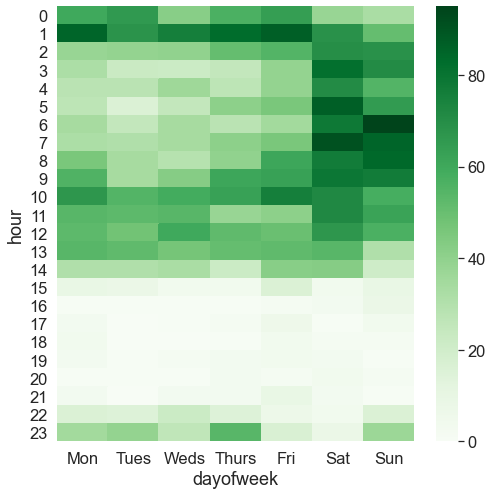

In [123]:
import seaborn as sns
#create overall weekly heatmap
fig4 = plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)
sns.heatmap(g, cmap="Greens")
#fig4.savefig("temporal_all_washFINAL.png")
plt.show()

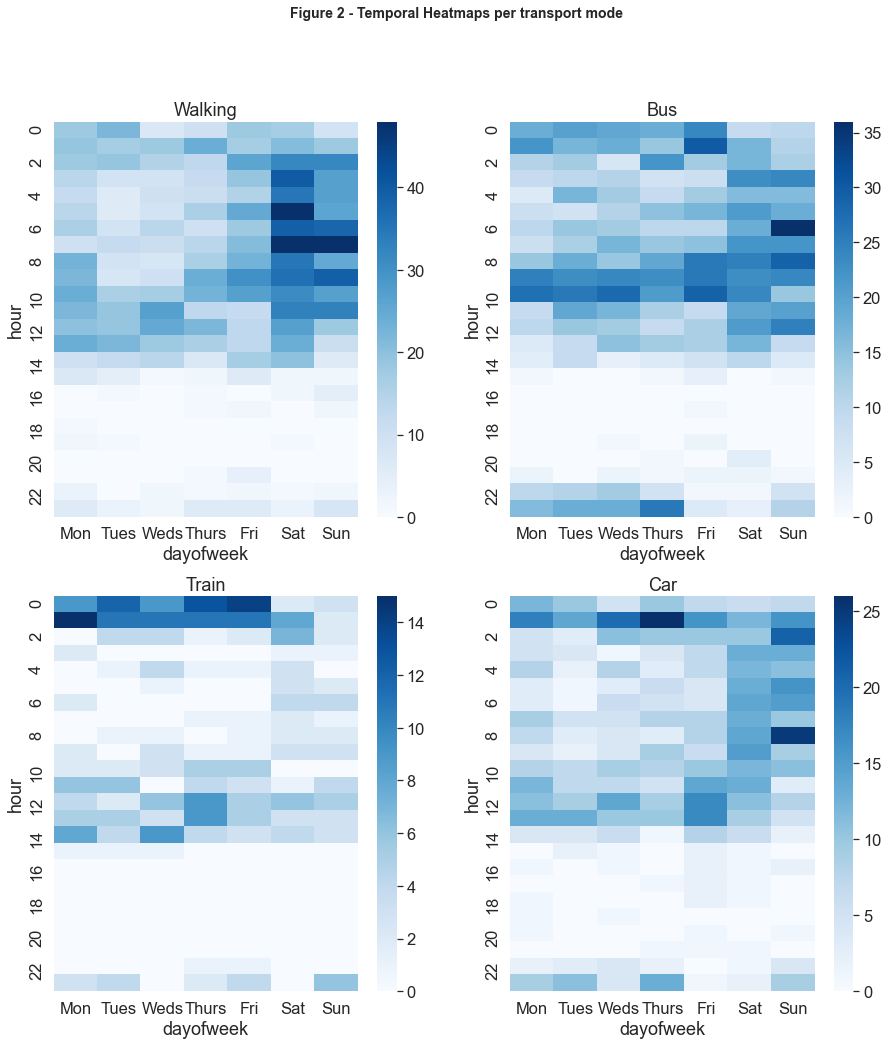

In [124]:
#Generate figure size as 15x16
fig4 = plt.figure(figsize=(15, 16))
#layout 2cols by 3rows
spec4 = fig4.add_gridspec(ncols=2, nrows=2)

#generate subplots in formation
f4_ax1 = fig4.add_subplot(spec4[0, 0])
f4_ax2 = fig4.add_subplot(spec4[0, 1])
f4_ax3 = fig4.add_subplot(spec4[1, 0])
f4_ax4 = fig4.add_subplot(spec4[1, 1])

sns.heatmap(h1, cmap="Blues", ax = f4_ax1)
sns.heatmap(h3, cmap="Blues", ax = f4_ax2)
sns.heatmap(h6, cmap="Blues", ax = f4_ax3)
sns.heatmap(h4, cmap="Blues", ax = f4_ax4)

f4_ax1.set_title('Walking')
f4_ax2.set_title('Bus')
f4_ax3.set_title('Train')
f4_ax4.set_title('Car')

fig4.suptitle("Figure 2 - Temporal Heatmaps per transport mode " ,
                 fontsize=14, fontweight='bold'
                  )
#fig4.savefig("temporal_modes_washFINAL.png")
plt.show()

## Create Confusion matrix

In [125]:
modes = ['walk','bus','car','train','x_unclassified']
cat_type2 = CategoricalDtype(categories=modes, ordered=True)
trips['inf_labels'] = trips['inf_labels'].astype(cat_type2)
trips['label'] = trips['label'].astype(cat_type2)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

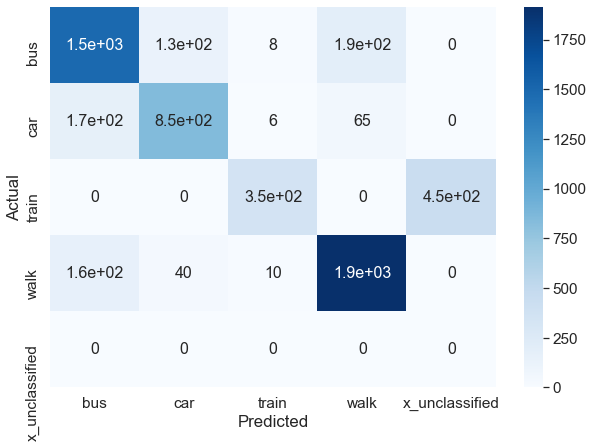

In [126]:
y_true = trips['label']
y_pred = trips['inf_labels']
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_pred), index = np.unique(y_pred))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


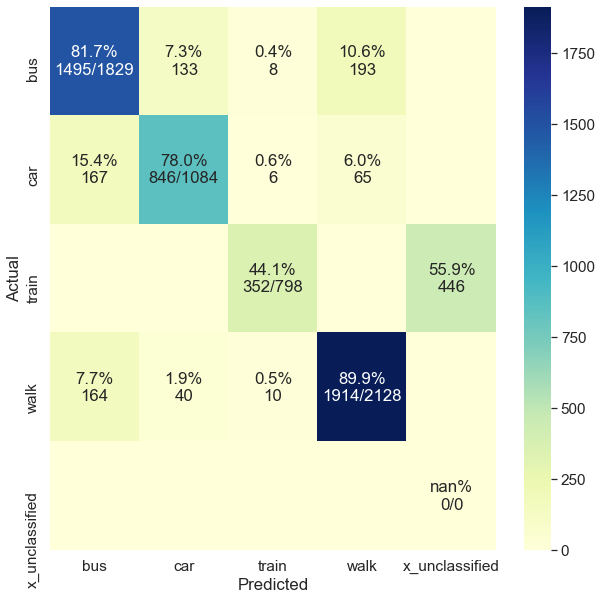

In [127]:
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_pred))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_pred), columns=np.unique(y_pred))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    fig.savefig("confusion_matrix_FINAL.png")
plot_cm(y_true, y_pred)

## Retreive Individual Confusion Matrix

In [128]:
wrong_labelled[['inf_labels']] = wrong_labelled[['inf_labels']].fillna(value=0)

In [129]:
wrong_labelled['inf_labels'] = wrong_labelled.apply(mode_of_trans2, axis=1)
wrong_labelled['label'] = wrong_labelled.apply(mode_of_trans, axis=1)
walk_and_train['inf_labels'] = walk_and_train.apply(mode_of_trans2, axis=1)
walk_and_train['label'] = walk_and_train.apply(mode_of_trans, axis=1)
#append tables
walk_and_train2 = walk_and_train.append(wrong_labelled)
cars_and_rest['label'] = cars_and_rest.apply(mode_of_trans, axis=1)
cars_and_rest['inf_labels'] = cars_and_rest.apply(mode_of_trans2, axis=1)

In [130]:
y_true_justT = walk_and_train2['label']
y_pred_justT = walk_and_train2['inf_labels']

### Rules-Based Confuion Matrix

C:\Users\ant-r\Miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

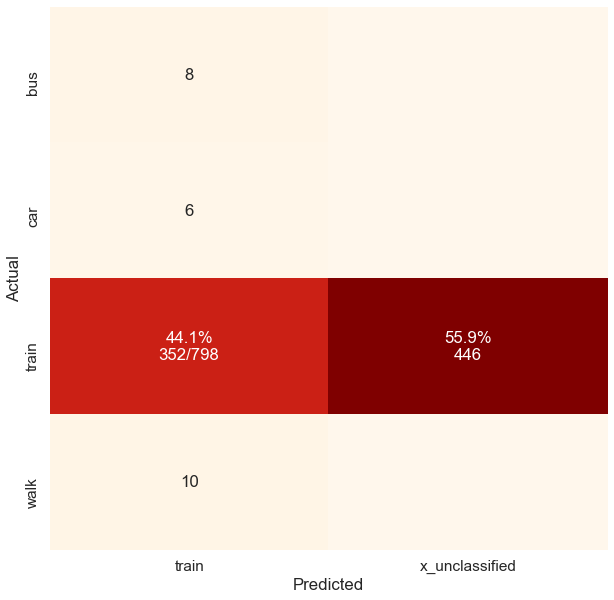

In [131]:
# Generate confusion matrix
cm = confusion_matrix(y_true_justT, y_pred_justT, labels=np.unique(modes))

cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(cm, index=np.unique(modes), columns=np.unique(modes))
cm.drop(['bus', 'car', 'walk'], axis=1, inplace=True)
cm.drop(['x_unclassified'], axis=0, inplace=True)
annot = np.delete(annot, np.s_[0:2], axis=1) 
annot = np.delete(annot, np.s_[1], axis=1) 
annot = np.delete(annot, np.s_[4], axis=0) 
for lst in annot:
    for j, item in enumerate(lst):
        lst[j] = item.replace('100.0%\n', '')
#annot = np.empty_like(cm).astype(str)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(cm, cmap= "OrRd", annot=annot, fmt='', ax=ax, cbar=False)
#fig.savefig("confusion_matrix_trains_2FINAL.png")

In [132]:
y_true_justrf = cars_and_rest['label']
y_pred_justrf = cars_and_rest['inf_labels']

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

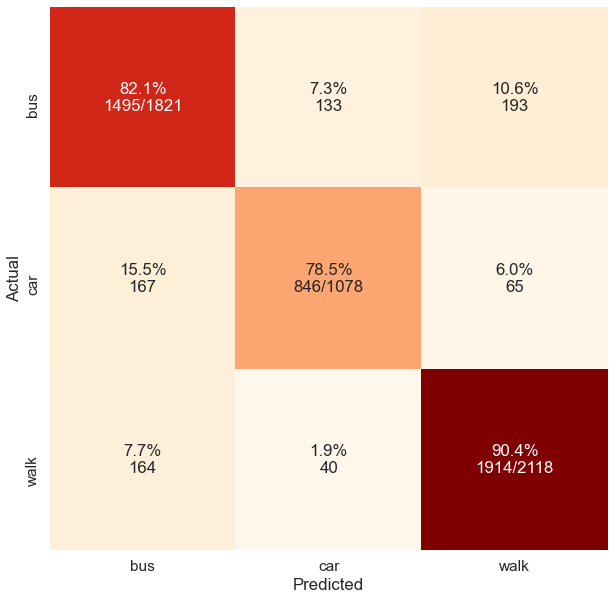

In [133]:
# Generate confusion matrix
cm = confusion_matrix(y_true_justrf, y_pred_justrf, labels=np.unique(y_pred_justrf))
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(cm, index=np.unique(y_pred_justrf), columns=np.unique(y_pred_justrf))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(cm, cmap= "OrRd", annot=annot, fmt='', ax=ax, cbar=False)
#fig.savefig("confusion_matrix_cars_w_b_FINAL.png")

In [134]:
print(classification_report(y_true_justT, y_pred_justT, zero_division=0)) #AFTER TRAIN INFERENCE

                precision    recall  f1-score   support

           bus       0.00      0.00      0.00         8
           car       0.00      0.00      0.00         6
         train       0.94      0.44      0.60       798
          walk       0.00      0.00      0.00        10
x_unclassified       0.00      0.00      0.00         0

      accuracy                           0.43       822
     macro avg       0.19      0.09      0.12       822
  weighted avg       0.91      0.43      0.58       822



In [135]:
print(classification_report(y_true_justrf, y_pred_justrf)) #AFTER OTHER MODES INFERENCE

              precision    recall  f1-score   support

         bus       0.82      0.82      0.82      1821
         car       0.83      0.78      0.81      1078
        walk       0.88      0.90      0.89      2118

    accuracy                           0.85      5017
   macro avg       0.84      0.84      0.84      5017
weighted avg       0.85      0.85      0.85      5017



In [136]:
print(classification_report(trips['label'], trips['inf_labels'], zero_division=0)) #OVER ALL DATA

                precision    recall  f1-score   support

           bus       0.82      0.82      0.82      1829
           car       0.83      0.78      0.80      1084
         train       0.94      0.44      0.60       798
          walk       0.88      0.90      0.89      2128
x_unclassified       0.00      0.00      0.00         0

      accuracy                           0.79      5839
     macro avg       0.69      0.59      0.62      5839
  weighted avg       0.86      0.79      0.81      5839



### Overall Bar charts

In [137]:
list1 = pd.DataFrame(trips['label'].value_counts()).reset_index()
list2 = pd.DataFrame(trips['inf_labels'].value_counts()).reset_index()

In [138]:
bar = pd.merge(list1,list2,on='index')

In [139]:
bar = bar.rename(columns={'index':'Transport_Mode'})

<Figure size 432x288 with 0 Axes>

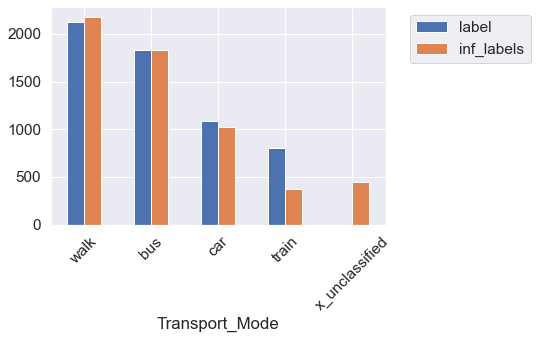

In [140]:
ax = plt.figure()
bar.plot.bar(x='Transport_Mode')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.set_xlabel('Transport Modes')
plt.savefig("count_plot_results_FINAL.png")
plt.show()

### Extract the model

In [ ]:
pickle.dump(rf_estimator, open('model_rf7_fresh.pkl','wb'))

## Create Origin Destination Matrix

In [ ]:
trips['labels'] = trips['labels'].astype(str)

In [ ]:
trips['labels'] = trips.apply(mode_of_trans, axis=1)

In [ ]:
#make a centroid point on the hex polygons
hex_grid['centroid'] = hex_grid.geometry.centroid
hex_grid6['centroid'] = hex_grid6.geometry.centroid

In [ ]:
#function to make a line a point for the origin point of the trip
def linestring_to_points(line):
    return line.coords[0]

In [ ]:
from shapely import wkt

In [ ]:
tripsA = gpd.GeoDataFrame(tripsA, geometry ='geometry' , crs='epsg:4326')

In [ ]:
#function to make a line a point for the destination point of the trip
def linestring_to_points_end(line):
    return line.coords[-1]

### Define variables fo the end of the trip

In [ ]:
tripsA['end_points'] = tripsA.apply(lambda l: linestring_to_points_end(l['geometry']),axis=1)
trips_end = tripsA.loc[:,['U_trip_ID','end_points']]
trips_end.rename(columns = {'end_points':'geometry'}, inplace = True)
trips_end['geometry']=gpd.points_from_xy(trips_end['geometry'].str[0], trips_end['geometry'].str[1])
trips_end = gpd.GeoDataFrame(trips_end, geometry='geometry', crs="EPSG:4326")
trips_end = gpd.sjoin(trips_end, hex_grid, how="inner", rsuffix="7" )
trips_end = trips_end.loc[:, trips_end.columns != 'index_7']
trips_end = gpd.sjoin(trips_end, hex_grid6, how="inner", rsuffix="6" )
trips_end = trips_end.loc[:, trips_end.columns != 'index_6']
trips_end = trips_end.rename(columns={'hex_id_left':'hex_id_7', 'centroid_left':'centroid_7'})

### Define variables for the start of the trip

In [ ]:
tripsA['start_points'] = tripsA.apply(lambda l: linestring_to_points(l['geometry']),axis=1)
trips_start = tripsA.loc[:,['U_trip_ID','total_trip_time','overall_full_dist','velo_mean','train_conf','bus_conf','min_dist_trns','dist_trns_line','labels','start_points','geometry','hour','dayofweek']]
trips_start['start_points']=gpd.points_from_xy(trips_start['start_points'].str[0], trips_start['start_points'].str[1])
trips_start = gpd.GeoDataFrame(trips_start, geometry='start_points', crs="EPSG:4326")
trips_start = gpd.sjoin(trips_start, hex_grid, how="inner", rsuffix="7" )
trips_start = trips_start.loc[:, trips_start.columns != 'index_7']
trips_start = gpd.sjoin(trips_start, hex_grid6, how="inner", rsuffix="6" )
trips_start = trips_start.loc[:, trips_start.columns != 'index_6']
trips_start = trips_start.rename(columns={'hex_id_left':'hex_id_7', 'centroid_left':'centroid_7'})

In [ ]:
#give the trip feature just a start and end geoemtry 
TripsA = pd.merge(trips_start, trips_end, left_on='U_trip_ID',right_on='U_trip_ID', suffixes=('_start', '_end'))
#rename geoemtry start to geoemtry so it can be make a geodataframe
TripsA.rename(columns = {'geometry_start':'geometry'}, inplace = True)
#set the geoemtry col
TripsA = TripsA.set_geometry('geometry')
TripsA = gpd.GeoDataFrame(TripsA, geometry='geometry', crs="EPSG:4326")

In [ ]:
#extract the lat and long of the start and end of the trip for the centroid of the hex polygon (zoom level 7)
TripsA['source_long_7'] = TripsA.centroid_7_start.x
TripsA['source_lat_7'] = TripsA.centroid_7_start.y
TripsA['end_long_7'] = TripsA.centroid_7_end.x
TripsA['end_lat_7'] = TripsA.centroid_7_end.y

In [ ]:
#extract the lat and long of the start and end of the trip for the centroid of the hex polygon (zoom level 6)
TripsA['source_long_6'] = TripsA.centroid_6_start.x
TripsA['source_lat_6'] = TripsA.centroid_6_start.y
TripsA['end_long_6'] = TripsA.centroid_6_end.x
TripsA['end_lat_6'] = TripsA.centroid_6_end.y

In [ ]:
#change the labels from numbers to strings
def mode_of_trans(row):
    if row['labels'] == '1':
        val = 'walk'
    elif row['labels'] == '3':
        val = 'bus'
    elif row['labels'] == '4':
        val = 'car'
    else:
        val = 'train'
    return val

In [ ]:
#apply the fuction to make string names
TripsA['labels'] = TripsA.apply(mode_of_trans, axis=1)

In [ ]:
#define the hex_ids covering Washington CBD
columns1 = ['862aa845fffffff','862aa844fffffff',  '862aa8447ffffff', '862aa8457ffffff']

## Grouped trips by label at zoom level 6 with same OD

In [ ]:
#group the trips with the same start and end 
TripsA_grouped6 = TripsA.groupby(['hex_id_6_start','hex_id_6_end']).agg({'U_trip_ID':'count','overall_full_dist':'mean','total_trip_time':'mean','velo_mean':'mean','source_long_6':'first','source_lat_6':'first','end_long_6':'first','end_lat_6':'first'}).reset_index()
#group the trips with the same start and end and labels
TripsA_grouped6_labels = TripsA.groupby(['hex_id_6_start','hex_id_6_end','labels']).agg({'U_trip_ID':'count','overall_full_dist':'mean','total_trip_time':'mean','velo_mean':'mean','source_long_6':'first','source_lat_6':'first','end_long_6':'first','end_lat_6':'first'}).reset_index()
#ensure there is more than for trips within a hex cell
TripsA_grouped6_labels = TripsA_grouped6_labels[TripsA_grouped6_labels['U_trip_ID']>=4]
#make the Uid a count label as this is what is represents
TripsA_grouped6_labels = TripsA_grouped6_labels.rename(columns={'U_trip_ID': 'count'})
#make the labels a string
TripsA_grouped6_labels['labels'] = TripsA_grouped6_labels['labels'].astype(str)
#make sure that the start is not the same as the end hex cell
TripsA_grouped6_labels = TripsA_grouped6_labels[TripsA_grouped6_labels['hex_id_6_start'] != TripsA_grouped6_labels['hex_id_6_end']]

In [ ]:
All_everywhere = TripsA_grouped6_labels[TripsA_grouped6_labels['count']>5]
All_everywhere.to_csv(r'All_everywhereFINAL.csv', index = False)

### top ten trips by label

In [ ]:
#extract from all the trips grouped with same origin and destination and label
TripsA_grouped6_labelsTop10 = TripsA_grouped6_labels.groupby(["labels"]).apply(lambda x: x.sort_values(["U_trip_ID"], ascending = False)).reset_index(drop=True)
#grab the top ten
TripsA_grouped6_labelsTop10 = TripsA_grouped6_labelsTop10.head(10)

### Extract trips at zoom level 7 for each transport mode

In [ ]:
#cgroup trips with same start and end and label
TripsA_grouped7 = TripsA.groupby(['hex_id_7_start','hex_id_7_end','labels']).agg({'U_trip_ID':'count','overall_full_dist':'mean','total_trip_time':'mean','velo_mean':'mean','source_long_7':'first','source_lat_7':'first','end_long_7':'first','end_lat_7':'first'}).reset_index()
#end must be different to the start
TripsA_grouped7 = TripsA_grouped7[TripsA_grouped7['hex_id_7_start'] != TripsA_grouped7['hex_id_7_end']]
#rename the count 
TripsA_grouped7 = TripsA_grouped7.rename(columns={'U_trip_ID': 'count'})
#extract each mode by label
walk = TripsA_grouped7[TripsA_grouped7['labels']=='walk'].reset_index(drop=True)
car = TripsA_grouped7[TripsA_grouped7['labels']=='car'].reset_index(drop=True)
bus = TripsA_grouped7[TripsA_grouped7['labels']=='bus'].reset_index(drop=True)
train = TripsA_grouped6_labels[TripsA_grouped6_labels['labels']=='train'].reset_index(drop=True)

### Process to get trips by transport label without a specific direction

Process define in first cell is same in all modes

In [ ]:
#break the start and end into a lsit column
car['list']=car[['hex_id_7_start','hex_id_7_end']].values.tolist()
#apply sorting to the list
car['list']= car['list'].apply(sorted)
#take the first in the list now as the start (not actually start but just the first we will take)
car['hex_id_7_start'] = car['list'].str[0]
#take the second in the list and make this the second geom
car['hex_id_7_end'] = car['list'].str[1]
#take the cars witht he same routes
car = car.groupby(['hex_id_7_start','hex_id_7_end']).agg({'count':'sum','overall_full_dist':'mean','total_trip_time':'mean','velo_mean':'mean','source_long_7':'first','source_lat_7':'first','end_long_7':'first','end_lat_7':'first'}).reset_index()
#sort the cars by count
car = car.sort_values('count', ascending = False).head(10).reset_index()

In [ ]:
walk['list']=walk[['hex_id_7_start','hex_id_7_end']].values.tolist()
walk['list']= walk['list'].apply(sorted)
walk['hex_id_7_start'] = walk['list'].str[0]
walk['hex_id_7_end'] = walk['list'].str[1]
walk = walk.groupby(['hex_id_7_start','hex_id_7_end']).agg({'count':'sum','total_trip_time':'mean','overall_full_dist':'mean','velo_mean':'mean','source_long_7':'first','source_lat_7':'first','end_long_7':'first','end_lat_7':'first'}).reset_index()
walk = walk.sort_values('count', ascending = False).head(5).reset_index()

In [ ]:
train['list']=train[['hex_id_6_start','hex_id_6_end']].values.tolist()
train['list']= train['list'].apply(sorted)
train['hex_id_6_start'] = train['list'].str[0]
train['hex_id_6_end'] = train['list'].str[1]
train = train.groupby(['hex_id_6_start','hex_id_6_end']).agg({'count':'sum','total_trip_time':'mean','overall_full_dist':'mean','velo_mean':'mean','source_long_6':'first','source_lat_6':'first','end_long_6':'first','end_lat_6':'first'}).reset_index()
train = train.sort_values('count', ascending = False).head(5).reset_index()

In [ ]:
bus['list']=bus[['hex_id_7_start','hex_id_7_end']].values.tolist()
bus['list']= bus['list'].apply(sorted)
bus['hex_id_7_start'] = bus['list'].str[0]
bus['hex_id_7_end'] = bus['list'].str[1]
bus = bus.groupby(['hex_id_7_start','hex_id_7_end']).agg({'count':'sum','total_trip_time':'mean','overall_full_dist':'mean','velo_mean':'mean','source_long_7':'first','source_lat_7':'first','end_long_7':'first','end_lat_7':'first'}).reset_index()
bus = bus.sort_values('count', ascending = False).head(10).reset_index()

In [ ]:
#extract transport mode routes 
car.to_csv(r'cars2FINAL.csv', index = False)
bus.to_csv(r'bus2FINAL.csv', index = False)
walk.to_csv(r'walk2FINAL.csv', index = False)
train.to_csv(r'trainsFINAL.csv', index = False)

### Take the trips going in and out of the city centre by transport mode

In [ ]:
#take cars that start in the city centre
TripsA_grouped6_out_city_car = car[car['hex_id_6_start'].isin(columns1)].sort_values('count', ascending = False)
TripsA_grouped6_out_city_car = TripsA_grouped6_out_city_car[~TripsA_grouped6_out_city_car['hex_id_6_end'].isin(columns1)]
#take buses that start in the city centre
TripsA_grouped6_out_city_bus = bus[bus['hex_id_6_start'].isin(columns1)].sort_values('count', ascending = False)
TripsA_grouped6_out_city_bus = TripsA_grouped6_out_city_bus[~TripsA_grouped6_out_city_bus['hex_id_6_end'].isin(columns1)]
##take walker that start in the city centre
TripsA_grouped6_out_city_walk = walk[walk['hex_id_6_start'].isin(columns1)].sort_values('count', ascending = False)
TripsA_grouped6_out_city_walk = TripsA_grouped6_out_city_walk[~TripsA_grouped6_out_city_walk['hex_id_6_end'].isin(columns1)]
##take trains that start in the city centre
TripsA_grouped6_out_city_train = train[train['hex_id_6_start'].isin(columns1)].sort_values('count', ascending = False)
TripsA_grouped6_out_city_train = TripsA_grouped6_out_city_train[~TripsA_grouped6_out_city_train['hex_id_6_end'].isin(columns1)]

In [ ]:
# Take all trips going in and out of city centre (not by transport mode)
TripsA_grouped6_out_city = TripsA_grouped6[TripsA_grouped6['hex_id_6_start'].isin(columns1)].sort_values('U_trip_ID', ascending = False)
TripsA_grouped6_out_city = TripsA_grouped6_out_city[~TripsA_grouped6_out_city['hex_id_6_end'].isin(columns1)]
TripsA_grouped6_in_city = TripsA_grouped6[TripsA_grouped6['hex_id_6_end'].isin(columns1)].sort_values('U_trip_ID', ascending = False)
TripsA_grouped6_in_city = TripsA_grouped6_in_city[~TripsA_grouped6_in_city['hex_id_6_start'].isin(columns1)]

In [ ]:
#Take all trips into the city centre (not by transport mode)
TripsA_grouped6_in_city = TripsA_grouped6_in_city.reset_index()
TripsA_grouped6_in_city = TripsA_grouped6_in_city.sort_values('count', ascending = False).head(15)
TripsA_grouped6_out_city = TripsA_grouped6_out_city.reset_index()
TripsA_grouped6_out_city = TripsA_grouped6_out_city.sort_values('count', ascending = False).head(15)

In [ ]:
#extract the labeled in and out of city centre trips
TripsA_grouped6_out_city_car.to_csv(r'TripsA_grouped6_out_city_car.csv', index = False)
TripsA_grouped6_out_city_bus.to_csv(r'TripsA_grouped6_out_city_bus.csv', index = False)
TripsA_grouped6_out_city_walk.to_csv(r'TripsA_grouped6_out_city_walk.csv', index = False)
TripsA_grouped6_out_city_train.to_csv(r'TripsA_grouped6_out_city_trains.csv', index = False)

In [ ]:
#TripsA_grouped6_labels.to_csv(r'TripsA_grouped6_labelsFINAL.csv', index = False)

### Take the trips going in and out of the city at certain times

In [ ]:
#define a function to label trips between specific hours (morning and evening peak travel)
def label_time(row):
    if (row['hour'] >= 6) & (row['hour'] <= 10)  :
        val= 'am'
    elif (row['hour'] >= 16) & (row['hour'] <= 20) :
        val= 'pm'
    else:
        val= None
    return val

In [ ]:
#apply function
TripsA['time'] = TripsA.apply(label_time, axis=1) 
##only retain the trips on a weekday
TripsA_weekday = TripsA[~TripsA['dayofweek'].isin(['sat','sun'])]
#ensure that the start is not the same as the end
TripsA_time = TripsA_weekday[TripsA_weekday['hex_id_7_start'] != TripsA_weekday['hex_id_7_end']]
#rename the trip id column to a count
TripsA_time = TripsA_time.rename(columns={'U_trip_ID': 'count'})
#only keep the weekdays
TripsA_time = TripsA_time[TripsA_time.time.notnull()]

In [ ]:
#groupby trips with the same destination and the 2 times 'am' and 'pm'
TripsA_time  = TripsA_time.groupby(['hex_id_7_end', 'time']).agg({'count':'count'}).reset_index()
TripsA_time = TripsA_time[TripsA_time['count']>=3]

In [ ]:
#extract trips
TripsA_time[TripsA_time['time']=='am'].to_csv(r'am_trips_weekFINAL.csv', index = False)
TripsA_time[TripsA_time['time']=='pm'].to_csv(r'pm_trips_weekFINAL.csv', index = False)

### Take the trips going in and out of the city centre by any transport mode

In [ ]:
#start cannot be same as end
TripsA_grouped6 = TripsA_grouped6[TripsA_grouped6['hex_id_6_start'] != TripsA_grouped6['hex_id_6_end']]
#rename the count col
TripsA_grouped6 = TripsA_grouped6.rename(columns={'U_trip_ID': 'count'})
#group all those going out of the city and sort by count
TripsA_grouped6_out_city = TripsA_grouped6[TripsA_grouped6['hex_id_6_start'].isin(columns1)].sort_values('count', ascending = False)
TripsA_grouped6_out_city = TripsA_grouped6_out_city[~TripsA_grouped6_out_city['hex_id_6_end'].isin(columns1)]
#group those going into the city and sort by count
TripsA_grouped6_in_city = TripsA_grouped6[TripsA_grouped6['hex_id_6_end'].isin(columns1)].sort_values('count', ascending = False)
TripsA_grouped6_in_city = TripsA_grouped6_in_city[~TripsA_grouped6_in_city['hex_id_6_start'].isin(columns1)]
TripsA_grouped6_in_city = TripsA_grouped6_in_city.reset_index(drop=True)
TripsA_grouped6_out_city = TripsA_grouped6_out_city.reset_index(drop=True)
#ensure they are over 4km trips
TripsA_grouped6_out_cityTop10_far = TripsA_grouped6_out_city[TripsA_grouped6_out_city['overall_full_dist']>=4].head(10).reset_index(drop=True)
TripsA_grouped6_in_cityTop10_far = TripsA_grouped6_in_city[TripsA_grouped6_in_city['overall_full_dist']>=4].head(10).reset_index(drop=True)

### In and out of city centre by distance over 4km

In [ ]:
TripsA_grouped6_in_cityTop10_far = TripsA_grouped6_in_cityTop10_far[TripsA_grouped6_in_cityTop10_far['count']>4]
TripsA_grouped6_out_cityTop10_far = TripsA_grouped6_out_cityTop10_far[TripsA_grouped6_out_cityTop10_far['count']>4]

In [ ]:
TripsA_grouped6_in_cityTop10_far.to_csv(r'TripsA_grouped6_in_city_dist10aFINAL.csv', index = False)
TripsA_grouped6_out_cityTop10_far.to_csv(r'TripsA_grouped6_out_city_dist10aFINAL.csv', index = False)

In [ ]:
TripsA_grouped6_out_city_labels = TripsA_grouped6_labels[TripsA_grouped6_labels['hex_id_6_start'].isin(columns1)].sort_values('count', ascending = False)
TripsA_grouped6_out_city_labels = TripsA_grouped6_out_city_labels[~TripsA_grouped6_out_city_labels['hex_id_6_end'].isin(columns1)]
TripsA_grouped6_in_city_labels = TripsA_grouped6_labels[TripsA_grouped6_labels['hex_id_6_end'].isin(columns1)].sort_values('count', ascending = False)
TripsA_grouped6_in_city_labels = TripsA_grouped6_in_city_labels[~TripsA_grouped6_in_city_labels['hex_id_6_start'].isin(columns1)]

In [ ]:
TripsA_grouped6_in_city_labels.to_csv(r'TripsA_grouped6_in_city_labelsFINAL.csv', index = False)
TripsA_grouped6_out_city_labels.to_csv(r'TripsA_grouped6_out_city_labelsFINAL.csv', index = False)